# ImageCLEF Medical Caption Task 2019

The Image CLEF 2019 Concept Detection Task is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images. Implement a system to classify a medical image based on several abnormalities represented by Unified Medical Language System (UMLS) concept IDs.

The AUEB NLP Group won the competition with this paper. This assignment was prepared by Vasiliki Kougia and John Pavlopoulos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#preferred style
plt.style.use('ggplot')

import numpy as np
import cv2
import os
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))

from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

Using TensorFlow backend.


Read the labels

In [3]:
string_consepts = 'ImageCLEF2019/string_concepts.csv'
train_consepts = 'ImageCLEF2019/train_concepts.csv'
val_concepts = 'ImageCLEF2019/val_concepts.csv'

str_con = pd.read_csv(string_consepts, sep='\t', header=None)
train_con = pd.read_csv(train_consepts)
val_con = pd.read_csv(val_concepts)

In [4]:
train_con

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743
...,...,...
56624,ROCO_CLEF_40405,C0040395;C0034579;C0015450;C0040405
56625,ROCO_CLEF_17150,C0286840;C3244287
56626,ROCO_CLEF_04341,C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627,ROCO_CLEF_36569,C0023890;C0441633;C3263723


Let's plot some images

In [5]:
training_set = 'ImageCLEF2019/training-set/'
test_set = 'ImageCLEF2019/test-set/'
validation_set = 'ImageCLEF2019/validation-set/'

In [20]:
train = []

time1 = time.time()   # to measure time taken

# Load in the images
for filepath in os.listdir(training_set):
    instances = cv2.imread(training_set + filepath, 0)
    train.append(instances)
    
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
    
# train = np.array(train, dtype="float") / 255.0

Time taken: 192.5 seconds


In [7]:
# test = []

# time1 = time.time()   # to measure time taken

# # Load in the images
# for filepath in os.listdir(test_set):
#     instances = cv2.imread(test_set + filepath, 0)
#     test.append(instances)
    
# print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
    
# # train = np.array(train, dtype="float") / 255.0

In [8]:
# validation_setdation = []

# time1 = time.time()   # to measure time taken

# # Load in the images
# for filepath in os.listdir(validation_set):
#     instances = cv2.imread(validation_set + filepath, 0)
#     validation.append(instances)
    
# print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
    
# # train = np.array(train, dtype="float") / 255.0

Let's discover some of the training images

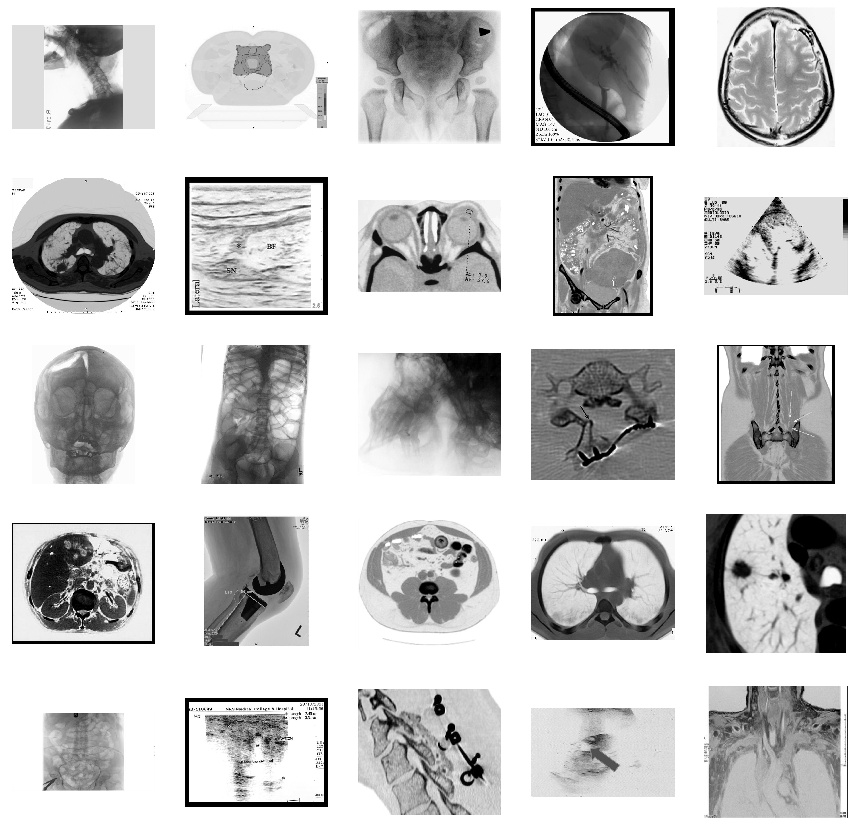

In [21]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap=plt.cm.binary)

Let's see some radiology images and the abnormality related to it 

In [22]:
# add header to str_con
str_con.rename(columns={0: 'tag', 1: 'tag_name'}, inplace=True)

In [23]:
# method that grabs all the tag names for the tag string given
def fetch_tags(tag):
    tags = tag.split(';')
    ids = []
    names = []
    for tag in tags:
        ids.append(tag)
        index = str_con.loc[str_con.tag == tag]
        names.append(index.tag_name.values[0])
    return ids, names

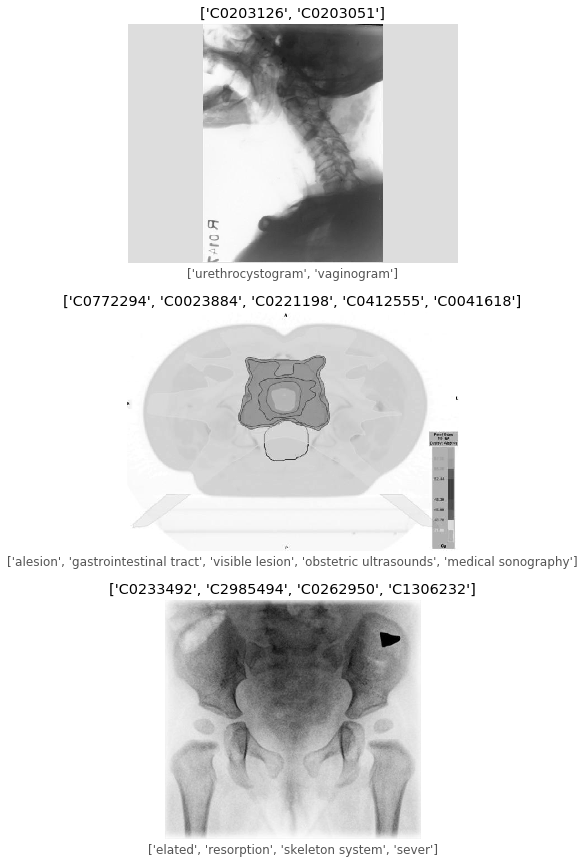

In [24]:
plt.figure(figsize=(15,15))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap=plt.cm.binary)
    ids, names = fetch_tags(train_con.iloc[i, 1])
    _ = plt.title(ids)
    _ = plt.xlabel(names)   

### How many tags are there in total?

#### Training

In [25]:
tags = val_con.iloc[:, 1]

In [26]:
sum_of_tags = 0
for tag in tags:
    items = tag.split(';')
    sum_of_tags += len(items)    

In [27]:
sum_of_tags

86927

which is the most frequent one?

In [28]:
# method that counts all the tag_ids and
# puts the in a dictionary
tag_dic = {}
for tag in tags:
    items = tag.split(';')
    for item in items:
        if item not in tag_dic.keys():
            tag_dic[item] = 1
        else:
            tag_dic[item] += 1

In [29]:
tag_df = pd.DataFrame.from_dict(tag_dic, orient='index', columns=['tag_count'])

get the tag_name column

In [30]:
str_con

,tag,tag_name
0,C0032143,r-tpa
1,C0225516,lower hypopharyngeal region
2,C0825429,bone surface
3,C0020461,excessive potassium in the blood
4,C0947912,proximal muscle weakness due to defect at the ...
...,...,...
5523,C0044955,prednylidene (pred)
5524,C3812869,medicated
5525,C2751430,camptodactyly and knuckle pads
5526,C0441621,sampled


In [31]:
tag_df = pd.merge(tag_df, str_con, left_index=True, right_on='tag', how='inner')

In [32]:
tag_df.reset_index(inplace=True)
tag_df.drop(columns=['index'], inplace=True)

In [65]:
tag_df.sort_values(by=['tag_count'], ascending=False, inplace=True)

In [66]:
tag_df

,tag_count,tag,tag_name
40,1692,C0441633,diagnostic scanning
24,1585,C0043299,x-ray procedure
23,1584,C1962945,radiogr
18,1489,C0817096,thoracics
20,1462,C0040395,tomogr
...,...,...,...
2338,1,C0179958,cleaners
2340,1,C0332575,rubor
2341,1,C0159075,milky urine
2342,1,C0180453,laryngoscope


In [73]:
first_ten = tag_df[:10]

In [78]:
reverse = first_ten[::-1]

In [79]:
reverse

,tag_count,tag,tag_name
88,1165,C0221198,visible lesion
86,1165,C0772294,alesion
124,1269,C1548003,radiograph
21,1363,C0040405,x-ray computer assisted tomography
16,1437,C0034579,pantomogr
20,1462,C0040395,tomogr
18,1489,C0817096,thoracics
23,1584,C1962945,radiogr
24,1585,C0043299,x-ray procedure
40,1692,C0441633,diagnostic scanning


<BarContainer object of 10 artists>

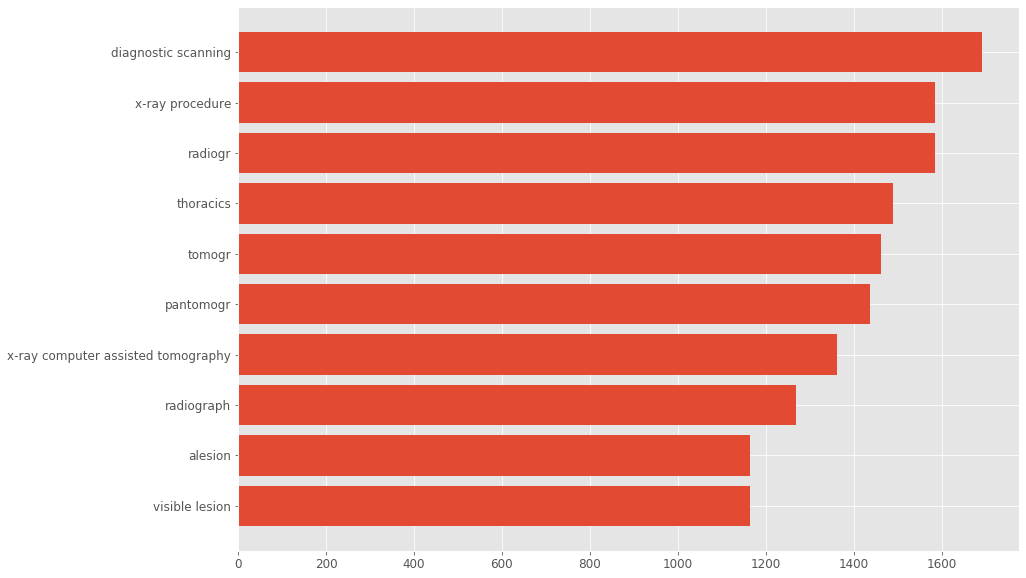

In [80]:
MEDIUM_SIZE = 12
plt.rc('font', size=MEDIUM_SIZE)     # fontsize of the axes title
plt.figure(figsize=[14, 10])
plt.barh(reverse.tag_name[:10], width=reverse.tag_count[:10])

In [ ]:
# trying to pivot the tags with the images

# columns = list(str_con.iloc[:, 0])

# index = list(train_con.iloc[:, 0])

# train_tagframe = pd.DataFrame(columns=columns, index=index)

# tags = train_con.iloc[:, 1]

Resources:
    
https://github.com/JNYH/Project_Kojak